<a href="https://colab.research.google.com/github/le7nik/project/blob/main/%D0%9E%D1%87%D0%B8%D1%81%D1%82%D0%BA%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%2C_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B0_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Закончено

In [ ]:
from matplotlib import pyplot as plt # для построения графиков
%matplotlib inline
import seaborn as sns # для построения матриц с корреляцией
import pandas as pd # для работы с дата сетом
import numpy as np
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split # разделение на части, основная и тренинговая
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# файлы скачал на диск, для удобства
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Final Project for Python BA/train.csv') 
df_macro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Final Project for Python BA/macro.csv')

In [ ]:
# Убираем id будет мешаться при дальнейших расчетах и валятся в признаках
df_train = df_train.drop(['id'], axis=1)

In [ ]:
# переводим колонку timestamp во время в обоих файлах
df_macro['timestamp'] = pd.to_datetime(df_macro['timestamp'])
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

In [ ]:
# склеиваем файлы в дата сет по timestamp
df_train = df_train.merge(df_macro, on = 'timestamp', how = 'inner')

In [ ]:
# извлекаем из колонки timestamp, данные для создания новых колонок (признаков) и замены изначальной timestamp
df_train['year_month'] = df_train['timestamp'].apply(lambda x: x.year * 100 + x.month).astype(int)
df_train['year'] = df_train['timestamp'].apply(lambda x: x.year).astype(int)
df_train['month'] = df_train['timestamp'].apply(lambda x: x.month).astype(int)
df_train.drop('timestamp', axis=1, inplace=True)

In [ ]:
df_train.shape

(30471, 392)

created missing indicator for: life_sq
created missing indicator for: floor
created missing indicator for: max_floor
created missing indicator for: material
created missing indicator for: build_year
created missing indicator for: num_room
created missing indicator for: kitch_sq
created missing indicator for: state
created missing indicator for: preschool_quota
created missing indicator for: school_quota
created missing indicator for: hospital_beds_raion
created missing indicator for: raion_build_count_with_material_info
created missing indicator for: build_count_block
created missing indicator for: build_count_wood
created missing indicator for: build_count_frame
created missing indicator for: build_count_brick
created missing indicator for: build_count_monolith
created missing indicator for: build_count_panel
created missing indicator for: build_count_foam
created missing indicator for: build_count_slag
created missing indicator for: build_count_mix
created missing indicator for: raio

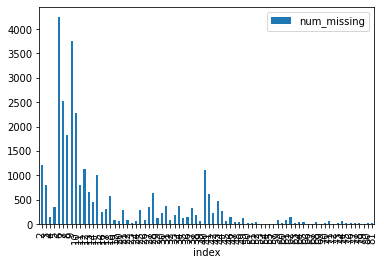

In [ ]:
# Составление гистограммы для пропущенных значений
for col in df_train.columns:
    missing = df_train[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df_train['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df_train.columns if 'ismissing' in col]
df_train['num_missing'] = df_train[ismissing_cols].sum(axis=1)

df_train['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [ ]:
missingValueCols = df_train.columns[df_train.isnull().any()].tolist() # если есть хоть одно нулевое значение оно попадет в этот список
mis_n = pd.isnull(df_train[missingValueCols]).sum().sort_values(ascending=False) / len (df_train)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # option_context - отображение на экране, в скобках - максимальное кол-во столбцов и строк
    print(mis_n) # вывели процент пропусков: provision_retail_space_modern_sqm         0.975288 - пропущено 97%

provision_retail_space_modern_sqm         0.975288
provision_retail_space_sqm                0.816481
students_reg_sports_share                 0.554659
theaters_viewers_per_1000_cap             0.554659
load_of_teachers_preschool_per_teacher    0.554659
museum_visitis_per_100_cap                0.554659
hospital_beds_raion                       0.473926
build_year                                0.446490
state                                     0.444980
cafe_avg_price_500                        0.435857
cafe_sum_500_max_price_avg                0.435857
cafe_sum_500_min_price_avg                0.435857
kitch_sq                                  0.314135
num_room                                  0.314135
material                                  0.314135
max_floor                                 0.314135
preschool_quota                           0.219487
school_quota                              0.219389
cafe_avg_price_1000                       0.214105
cafe_sum_1000_max_price_avg    

In [ ]:
# удаляем колонки, где больше 40% (0,4) пропущенных значений
a = mis_n[mis_n>0.40].index.to_list()
missingValueCols = [x for x in missingValueCols if x not in a]

df_train = df_train.drop(a, axis = 1) 
# создаем переменную в которую заносим список столбцов с пропущенными значениями без а, указанных в (missingValueCols), указываем ось = (axis = 1) т.е. удаляем по столбцам

In [ ]:
# процентный список пропущенных данных
for col in df_train.columns:
    pct_missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

full_sq - 0%
life_sq - 21%
floor - 1%
max_floor - 31%
material - 31%
num_room - 31%
kitch_sq - 31%
product_type - 0%
sub_area - 0%
area_m - 0%
raion_popul - 0%
green_zone_part - 0%
indust_part - 0%
children_preschool - 0%
preschool_quota - 22%
preschool_education_centers_raion - 0%
children_school - 0%
school_quota - 22%
school_education_centers_raion - 0%
school_education_centers_top_20_raion - 0%
healthcare_centers_raion - 0%
university_top_20_raion - 0%
sport_objects_raion - 0%
additional_education_raion - 0%
culture_objects_top_25 - 0%
culture_objects_top_25_raion - 0%
shopping_centers_raion - 0%
office_raion - 0%
thermal_power_plant_raion - 0%
incineration_raion - 0%
oil_chemistry_raion - 0%
radiation_raion - 0%
railroad_terminal_raion - 0%
big_market_raion - 0%
nuclear_reactor_raion - 0%
detention_facility_raion - 0%
full_all - 0%
male_f - 0%
female_f - 0%
young_all - 0%
young_male - 0%
young_female - 0%
work_all - 0%
work_male - 0%
work_female - 0%
ekder_all - 0%
ekder_male - 0%

От пропусков более 40% избавились, теперь нужно заняться проверками на наличие выбросов

In [ ]:
df_train.describe()

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm,year_month,year,month,num_missing
count,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,20899.000000,20899.000000,3.047100e+04,30471.000000,30471.000000,...,30471.000000,30471.000000,30471.000000,27232.000000,27232.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000
mean,54.214269,34.403271,7.670803,12.558974,1.827121,1.909804,6.399301,1.765705e+07,84056.425552,0.218922,...,9744.564143,0.447397,366627.117423,26.677108,44910.638807,229594.127331,201352.021791,2013.452726,6.749237,16.557940
std,38.031487,52.285733,5.319989,6.756550,1.481154,0.851805,28.265979,2.064961e+07,57871.285899,0.175090,...,857.611244,0.005793,55080.176499,2.016525,3854.550878,2767.547945,95.305846,0.962433,3.518748,14.763827
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.081628e+06,2546.000000,0.001879,...,6943.000000,0.439390,269768.000000,22.370000,23587.000000,226047.300000,201108.000000,2011.000000,1.000000,2.000000
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.000000,1.000000,7.307411e+06,21819.000000,0.063755,...,9350.000000,0.439390,329348.000000,26.700000,46080.000000,226047.300000,201304.000000,2013.000000,4.000000,7.000000
50%,49.000000,30.000000,6.500000,12.000000,1.000000,2.000000,6.000000,1.050803e+07,83502.000000,0.167526,...,10311.000000,0.447840,398451.000000,28.200000,46080.000000,229294.800000,201402.000000,2014.000000,6.000000,10.000000
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.000000,9.000000,1.803644e+07,122862.000000,0.336177,...,10311.000000,0.450700,398451.000000,28.200000,46352.000000,232840.200000,201409.000000,2014.000000,10.000000,22.000000
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,19.000000,2014.000000,2.060718e+08,247469.000000,0.852923,...,10805.000000,0.458880,463938.000000,28.200000,46352.000000,234576.900000,201506.000000,2015.000000,12.000000,81.000000


Судя по описанию дата сета выбросы есть

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 0 to 30470
Columns: 474 entries, full_sq to num_missing
dtypes: bool(93), float64(201), int64(162), object(18)
memory usage: 91.5+ MB


In [ ]:
# просмотр столбцов с типом данных "object"
obj_columns = list(df_train.select_dtypes(include=['object']).columns)
df_train[obj_columns]

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,child_on_acc_pre_school,modern_education_share,old_education_build_share
0,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good,#!,NaN,NaN
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent,#!,NaN,NaN
2,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor,#!,NaN,NaN
3,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good,#!,NaN,NaN
4,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent,#!,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,Investment,Otradnoe,no,no,yes,no,yes,no,no,no,no,no,no,no,good,NaN,"95,4918","8,2517"
30467,Investment,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor,NaN,"95,4918","8,2517"
30468,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data,NaN,"95,4918","8,2517"
30469,Investment,Obruchevskoe,no,no,no,no,yes,no,no,no,no,no,no,no,satisfactory,NaN,"95,4918","8,2517"


In [ ]:
# Чистим выборочно категориальные признаки
df_train['child_on_acc_pre_school'] = df_train['child_on_acc_pre_school'].replace('#!', np.nan) 
df_train['child_on_acc_pre_school'] = df_train['child_on_acc_pre_school'].apply(lambda x: float(x.replace(',','.')) if isinstance(x, str) == True else x)
df_train['modern_education_share'] = df_train['modern_education_share'].apply(lambda x: float(x.replace(',','.')) if isinstance(x, str) == True else x)
df_train['old_education_build_share'] = df_train['old_education_build_share'].apply(lambda x: float(x.replace(',','.')) if isinstance(x, str) == True else x)

In [ ]:
df_train['child_on_acc_pre_school'].value_counts()

16.765    13662
3.013      7978
7.311      4839
Name: child_on_acc_pre_school, dtype: int64

In [ ]:
df_train['ecology'].value_counts()

poor            8018
no data         7656
good            7174
excellent       3938
satisfactory    3685
Name: ecology, dtype: int64

In [ ]:
df_train['ecology'].describe()

count     30471
unique        5
top        poor
freq       8018
Name: ecology, dtype: object

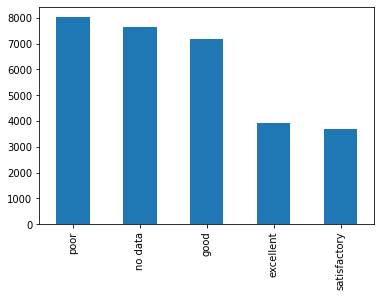

In [ ]:
df_train['ecology'].value_counts().plot.bar()

В признаке "ecology" распределение данных нормальное, единственное смущает массив no data.

# Далее выборка из зависимостей на таргет (price_doc) некоторых категориальных признаков.

---



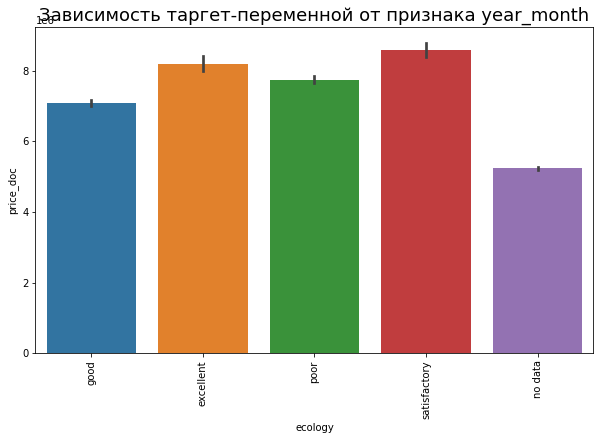

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='ecology', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака year_month', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

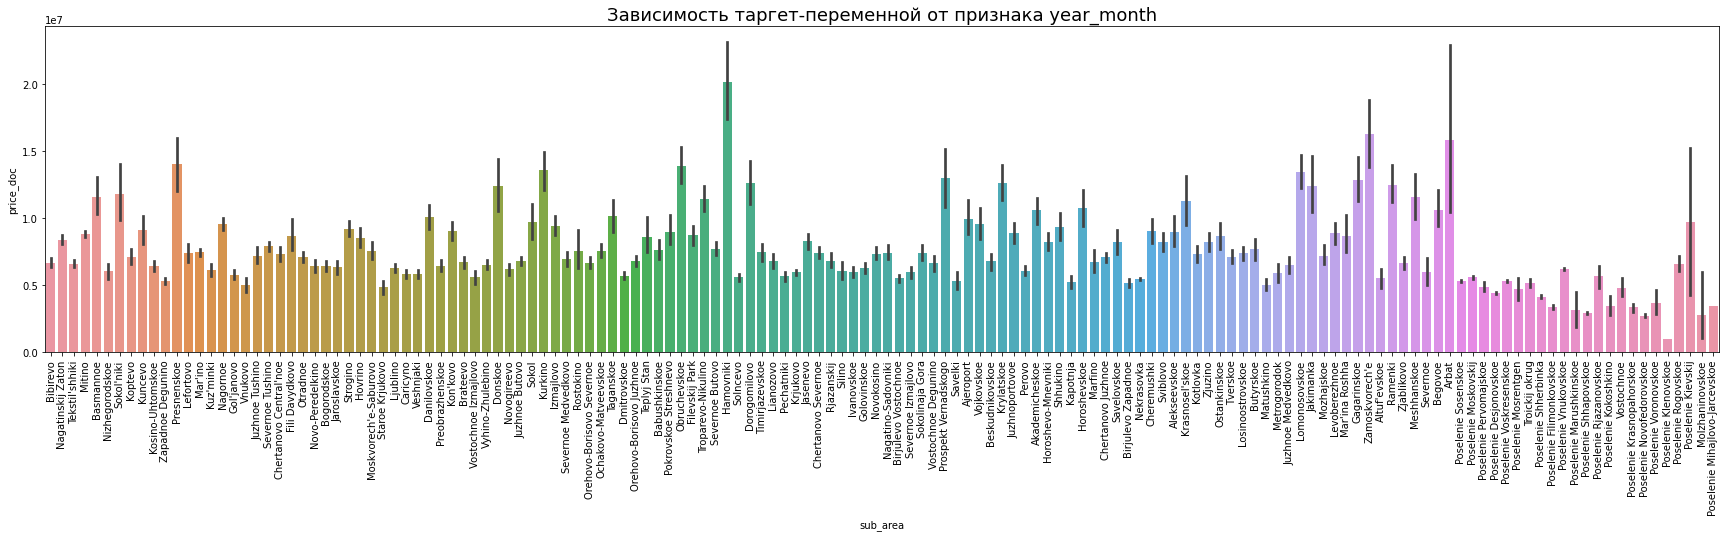

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
sns.barplot(x='sub_area', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака year_month', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

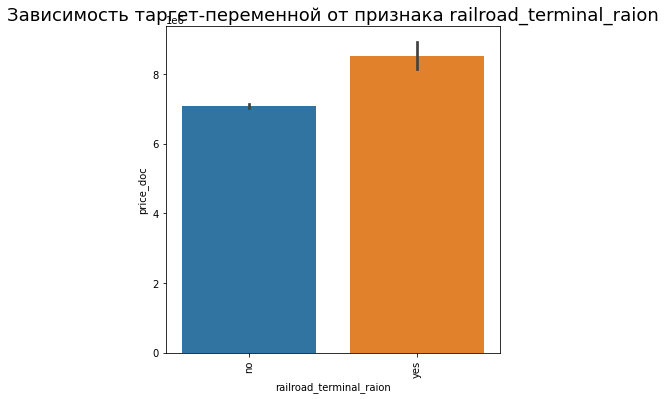

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='railroad_terminal_raion', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака railroad_terminal_raion', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

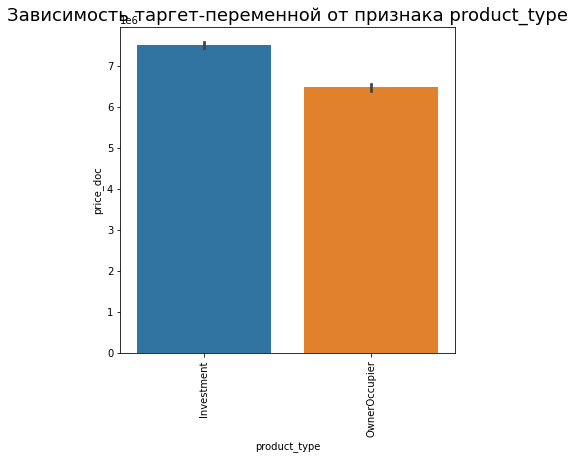

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='product_type', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака product_type', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

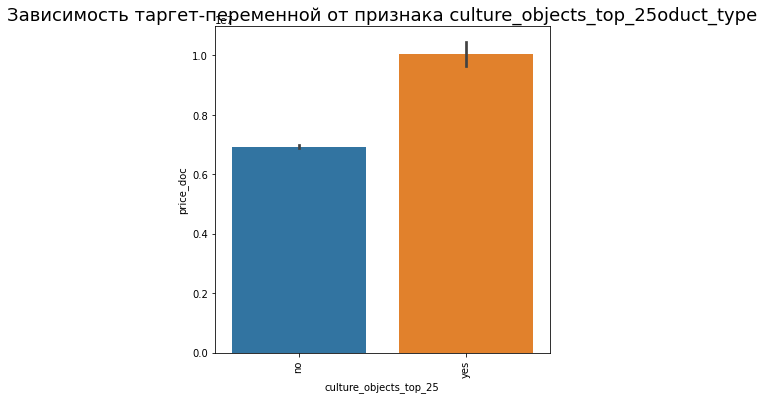

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='culture_objects_top_25', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака culture_objects_top_25oduct_type', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

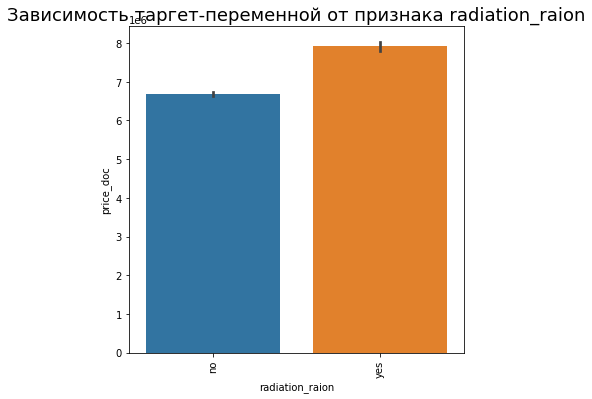

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='radiation_raion', y='price_doc', data=df_train)
plt.title('Зависимость таргет-переменной от признака radiation_raion', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

Далее, делим дата сет на два набора: числовой и категориальный.

In [ ]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index # в случае числовых значений
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index # в случае категориальных значений
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  459
Number of Categorical features:  15


In [ ]:
# Составляем список признаков у которых много повторений.т.е. более 95% строк содержит одно и тоже значение, для выявления не информативных
num_rows = len(df_train.index)
low_information_cols = [] 

for col in df_train.columns:
    cnts = df_train[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

oil_chemistry_raion: 99.02858%
no     30175
yes      296
Name: oil_chemistry_raion, dtype: int64

railroad_terminal_raion: 96.27187%
no     29335
yes     1136
Name: railroad_terminal_raion, dtype: int64

nuclear_reactor_raion: 97.16780%
no     29608
yes      863
Name: nuclear_reactor_raion, dtype: int64

big_road1_1line: 97.43691%
no     29690
yes      781
Name: big_road1_1line, dtype: int64

railroad_1line: 97.06934%
no     29578
yes      893
Name: railroad_1line, dtype: int64

cafe_count_500_price_high: 97.25641%
0    29635
1      787
2       38
3       11
Name: cafe_count_500_price_high, dtype: int64

mosque_count_500: 99.51101%
0    30322
1      149
Name: mosque_count_500, dtype: int64

cafe_count_1000_price_high: 95.52689%
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: cafe_count_1000_price_high, dtype: int64

mosque_count_1000: 98.08342%
0    29887
1      584
Name: mosque_count_1000, dtype: int64

mosque_count_1500: 96.21936%
0    29

In [ ]:
# в итоге получился небольшой список признаков для удаления, поскольку данные их полностью дублируются другими и не несет полезной информации

df_train = df_train.drop(['ID_railroad_station_walk_ismissing', 'cafe_sum_3000_min_price_avg_ismissing', 'cafe_avg_price_3000_ismissing', 'cafe_sum_5000_min_price_avg_ismissing', 'cafe_avg_price_5000_ismissing'], axis = 1)


Теперь можно заняться чисткой выбросов данных

In [ ]:
df_train.describe()

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm,year_month,year,month,num_missing
count,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,20899.000000,20899.000000,3.047100e+04,30471.000000,30471.000000,...,30471.000000,30471.000000,30471.000000,27232.000000,27232.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000
mean,54.214269,34.403271,7.670803,12.558974,1.827121,1.909804,6.399301,1.765705e+07,84056.425552,0.218922,...,9744.564143,0.447397,366627.117423,26.677108,44910.638807,229594.127331,201352.021791,2013.452726,6.749237,16.557940
std,38.031487,52.285733,5.319989,6.756550,1.481154,0.851805,28.265979,2.064961e+07,57871.285899,0.175090,...,857.611244,0.005793,55080.176499,2.016525,3854.550878,2767.547945,95.305846,0.962433,3.518748,14.763827
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.081628e+06,2546.000000,0.001879,...,6943.000000,0.439390,269768.000000,22.370000,23587.000000,226047.300000,201108.000000,2011.000000,1.000000,2.000000
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.000000,1.000000,7.307411e+06,21819.000000,0.063755,...,9350.000000,0.439390,329348.000000,26.700000,46080.000000,226047.300000,201304.000000,2013.000000,4.000000,7.000000
50%,49.000000,30.000000,6.500000,12.000000,1.000000,2.000000,6.000000,1.050803e+07,83502.000000,0.167526,...,10311.000000,0.447840,398451.000000,28.200000,46080.000000,229294.800000,201402.000000,2014.000000,6.000000,10.000000
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.000000,9.000000,1.803644e+07,122862.000000,0.336177,...,10311.000000,0.450700,398451.000000,28.200000,46352.000000,232840.200000,201409.000000,2014.000000,10.000000,22.000000
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,19.000000,2014.000000,2.060718e+08,247469.000000,0.852923,...,10805.000000,0.458880,463938.000000,28.200000,46352.000000,234576.900000,201506.000000,2015.000000,12.000000,81.000000


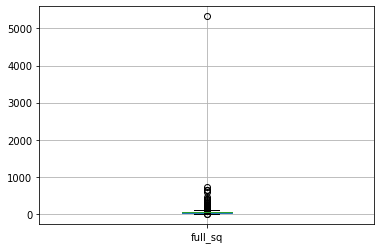

In [ ]:
# Проверяю на наличик выбросов
df_train.boxplot(column = ['full_sq'])

In [ ]:
# делим дата сет по признакам, поскольку работать будем с числовыми признаками, вариант более простой
df_num = df_train.select_dtypes(include=["number"])
df_cat = df_train.select_dtypes(exclude=["number"])

In [ ]:
# Убираем выбросы путем Q1 -1.5, Q3 + 1.5, т.е. уменьшили квартиль 1 на 1,5 и увеличили квартиль 3 на 1,5
# После обработки выбросов, объеденяем дата сет заново
Q1 = df_num.quantile(0.02)
Q3 = df_num.quantile(0.98)
IQR = Q3 - Q1
idx = ~((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any(axis=1)
df_cleaned = pd.concat([df_num.loc[idx], df_cat.loc[idx]], axis=1)

In [ ]:
df_cleaned.describe()

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm,year_month,year,month,num_missing
count,28121.000000,22208.000000,27971.000000,19744.000000,19744.000000,19744.000000,19744.000000,2.812100e+04,28121.000000,28121.000000,...,28121.000000,28121.000000,28121.000000,25078.000000,25078.000000,28121.000000,28121.000000,28121.000000,28121.000000,28121.000000
mean,53.349205,33.543678,7.695327,12.613402,1.810829,1.894500,5.773602,1.669987e+07,83465.735287,0.219074,...,9752.151382,0.447607,367418.410014,26.669860,44860.864343,229689.922617,201352.951175,2013.461150,6.836172,16.522457
std,19.921183,18.033664,5.272725,6.576717,1.471684,0.823269,3.968970,1.729452e+07,57315.131005,0.173797,...,867.484500,0.005708,55471.083495,2.050843,3908.399684,2739.824541,96.289920,0.972923,3.531026,14.584521
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.081628e+06,2546.000000,0.001879,...,6943.000000,0.439390,269768.000000,22.370000,23587.000000,226047.300000,201108.000000,2011.000000,1.000000,2.000000
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.000000,1.000000,7.307411e+06,21819.000000,0.063747,...,9350.000000,0.447840,329348.000000,26.700000,46080.000000,229294.800000,201304.000000,2013.000000,4.000000,7.000000
50%,49.000000,30.000000,7.000000,12.000000,1.000000,2.000000,6.000000,1.020722e+07,83502.000000,0.169625,...,10311.000000,0.447840,398451.000000,28.200000,46080.000000,229294.800000,201403.000000,2014.000000,7.000000,10.000000
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.000000,9.000000,1.752651e+07,118945.000000,0.338151,...,10311.000000,0.450700,398451.000000,28.200000,46352.000000,232840.200000,201409.000000,2014.000000,10.000000,22.000000
max,226.000000,191.000000,44.000000,48.000000,6.000000,8.000000,35.000000,1.186638e+08,247469.000000,0.852923,...,10805.000000,0.458880,463938.000000,28.200000,46352.000000,234576.900000,201506.000000,2015.000000,12.000000,77.000000


В итоге получил дата сет, очищенный и без выбросов

In [ ]:
correlation = df_cleaned.corr()
correlation

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,power_clinics_ismissing,hospital_beds_available_per_cap_ismissing,hospital_bed_occupancy_per_year_ismissing,provision_retail_space_sqm_ismissing,provision_retail_space_modern_sqm_ismissing,theaters_viewers_per_1000_cap_ismissing,museum_visitis_per_100_cap_ismissing,population_reg_sports_share_ismissing,students_reg_sports_share_ismissing,apartment_build_ismissing
full_sq,1.000000,0.788551,0.148853,0.131398,0.015110,0.760685,0.140180,0.115213,-0.083154,0.057941,...,0.064344,0.064344,0.064344,0.036423,0.037862,0.039115,0.039115,0.064344,0.039115,0.064344
life_sq,0.788551,1.000000,0.123830,0.124761,0.039965,0.611489,0.007236,0.181303,-0.155195,0.097302,...,0.047620,0.047620,0.047620,0.036872,0.041492,0.017028,0.017028,0.047620,0.017028,0.047620
floor,0.148853,0.123830,1.000000,0.455198,-0.013034,-0.010796,-0.016841,0.040813,-0.058174,0.020521,...,0.003400,0.003400,0.003400,0.002784,0.032402,-0.026197,-0.026197,0.003400,-0.026197,0.003400
max_floor,0.131398,0.124761,0.455198,1.000000,0.033765,-0.018179,0.190960,-0.027682,-0.038843,0.045023,...,0.016369,0.016369,0.016369,NaN,NaN,0.000769,0.000769,0.016369,0.000769,0.016369
material,0.015110,0.039965,-0.013034,0.033765,1.000000,-0.032861,0.162178,0.011067,-0.057176,0.026418,...,0.016742,0.016742,0.016742,NaN,NaN,-0.004544,-0.004544,0.016742,-0.004544,0.016742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
theaters_viewers_per_1000_cap_ismissing,0.039115,0.017028,-0.026197,0.000769,-0.004544,0.004699,-0.017965,-0.001818,-0.000396,0.040516,...,0.303607,0.303607,0.303607,0.555491,0.185453,1.000000,1.000000,0.303607,1.000000,0.303607
museum_visitis_per_100_cap_ismissing,0.039115,0.017028,-0.026197,0.000769,-0.004544,0.004699,-0.017965,-0.001818,-0.000396,0.040516,...,0.303607,0.303607,0.303607,0.555491,0.185453,1.000000,1.000000,0.303607,1.000000,0.303607
population_reg_sports_share_ismissing,0.064344,0.047620,0.003400,0.016369,0.016742,0.032551,-0.012832,0.041978,-0.033498,0.050718,...,1.000000,1.000000,1.000000,0.168651,0.056305,0.303607,0.303607,1.000000,0.303607,1.000000
students_reg_sports_share_ismissing,0.039115,0.017028,-0.026197,0.000769,-0.004544,0.004699,-0.017965,-0.001818,-0.000396,0.040516,...,0.303607,0.303607,0.303607,0.555491,0.185453,1.000000,1.000000,0.303607,1.000000,0.303607


In [ ]:
corr_matrix = df_cleaned.corr().abs()


df_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
df_corr.head(20)

childbirth                     water_pipes_share                              1.0
marriages_per_1000_cap         modern_education_share                         1.0
heating_share                  old_house_share                                1.0
water_pipes_share              provision_retail_space_modern_sqm_ismissing    1.0
baths_share                    provision_retail_space_modern_sqm_ismissing    1.0
modern_education_share         hospital_beds_available_per_cap                1.0
metro_min_walk                 metro_km_walk                                  1.0
old_education_build_share      population_reg_sports_share                    1.0
infant_mortarity_per_1000_cap  old_education_build_share                      1.0
electric_stove_share           old_education_build_share                      1.0
construction_value             old_education_build_share                      1.0
invest_fixed_assets_phys       modern_education_share                         1.0
modern_education

In [ ]:
correlation_1 = df_cleaned.corr().unstack().sort_values().drop_duplicates()

In [ ]:
correlation_1.head(20)

childbirth                                   water_pipes_share                             -1.0
heating_share                                old_house_share                               -1.0
provision_retail_space_modern_sqm_ismissing  water_pipes_share                             -1.0
baths_share                                  provision_retail_space_modern_sqm_ismissing   -1.0
hospital_beds_available_per_cap              modern_education_share                        -1.0
infant_mortarity_per_1000_cap                old_education_build_share                     -1.0
invest_fixed_assets_phys                     modern_education_share                        -1.0
hospital_bed_occupancy_per_year              modern_education_share                        -1.0
heating_share                                provision_retail_space_modern_sqm_ismissing   -1.0
childbirth                                   baths_share                                   -1.0
old_education_build_share               

Отобрал признаки

In [ ]:
# Забыл про нулевые значения
df_cleaned[df_cleaned.isnull().any(axis=1)]

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,power_clinics_ismissing,hospital_beds_available_per_cap_ismissing,hospital_bed_occupancy_per_year_ismissing,provision_retail_space_sqm_ismissing,provision_retail_space_modern_sqm_ismissing,theaters_viewers_per_1000_cap_ismissing,museum_visitis_per_100_cap_ismissing,population_reg_sports_share_ismissing,students_reg_sports_share_ismissing,apartment_build_ismissing
0,43,27.0,4.0,NaN,NaN,NaN,NaN,6.407578e+06,155572,0.189727,...,False,False,False,False,False,False,False,False,False,False
1,34,19.0,3.0,NaN,NaN,NaN,NaN,9.589337e+06,115352,0.372602,...,False,False,False,False,False,False,False,False,False,False
2,43,29.0,2.0,NaN,NaN,NaN,NaN,4.808270e+06,101708,0.112560,...,False,False,False,False,False,False,False,False,False,False
3,89,50.0,9.0,NaN,NaN,NaN,NaN,1.258354e+07,178473,0.194703,...,False,False,False,False,False,False,False,False,False,False
4,77,77.0,4.0,NaN,NaN,NaN,NaN,8.398461e+06,108171,0.015234,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30464,56,51.0,19.0,19.0,1.0,2.0,1.0,4.441296e+06,60315,0.137976,...,True,True,True,True,True,True,True,True,True,True
30465,52,NaN,13.0,17.0,1.0,2.0,1.0,7.307411e+06,75377,0.065444,...,True,True,True,True,True,True,True,True,True,True
30466,44,27.0,7.0,9.0,1.0,2.0,6.0,1.005305e+07,175518,0.096270,...,True,True,True,True,True,True,True,True,True,True
30468,45,NaN,10.0,20.0,1.0,1.0,1.0,2.553630e+07,4001,0.496315,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
df_cleaned.fillna(0)

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,power_clinics_ismissing,hospital_beds_available_per_cap_ismissing,hospital_bed_occupancy_per_year_ismissing,provision_retail_space_sqm_ismissing,provision_retail_space_modern_sqm_ismissing,theaters_viewers_per_1000_cap_ismissing,museum_visitis_per_100_cap_ismissing,population_reg_sports_share_ismissing,students_reg_sports_share_ismissing,apartment_build_ismissing
0,43,27.0,4.0,0.0,0.0,0.0,0.0,6.407578e+06,155572,0.189727,...,False,False,False,False,False,False,False,False,False,False
1,34,19.0,3.0,0.0,0.0,0.0,0.0,9.589337e+06,115352,0.372602,...,False,False,False,False,False,False,False,False,False,False
2,43,29.0,2.0,0.0,0.0,0.0,0.0,4.808270e+06,101708,0.112560,...,False,False,False,False,False,False,False,False,False,False
3,89,50.0,9.0,0.0,0.0,0.0,0.0,1.258354e+07,178473,0.194703,...,False,False,False,False,False,False,False,False,False,False
4,77,77.0,4.0,0.0,0.0,0.0,0.0,8.398461e+06,108171,0.015234,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30464,56,51.0,19.0,19.0,1.0,2.0,1.0,4.441296e+06,60315,0.137976,...,True,True,True,True,True,True,True,True,True,True
30465,52,0.0,13.0,17.0,1.0,2.0,1.0,7.307411e+06,75377,0.065444,...,True,True,True,True,True,True,True,True,True,True
30466,44,27.0,7.0,9.0,1.0,2.0,6.0,1.005305e+07,175518,0.096270,...,True,True,True,True,True,True,True,True,True,True
30468,45,0.0,10.0,20.0,1.0,1.0,1.0,2.553630e+07,4001,0.496315,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# Далее сортируем столбцы по количеству уникальных значений, для замены пропущенных значений на среднее значение в колонке, далее описание процесса
missingValueCols = df_cleaned.columns[df_cleaned.isnull().any()].tolist()
res = df_cleaned[missingValueCols].nunique().sort_values(ascending=False)

In [ ]:
# # замена значений спомощью mode() - замена значении на те что чаще всего встречаются в столбцах со значениями до 200, mode - используется когда кол-во уникальных значений ограниченно, также возможно использование медианы
# замена значений спомощью mean() - замена на средние в столбцах со значениями от 200
сols_fillna_mode = res[res<200].index.to_list()
cols_fillna_mean = res[res>200].index.to_list()

In [ ]:
for col in сols_fillna_mode:
    df_cleaned[col].fillna(df_cleaned[col].mode().iloc[0],inplace=True)
    
for col in cols_fillna_mean:
    df_cleaned[col].fillna(df_cleaned[col].mean(),inplace=True)

In [ ]:
df_cleaned[df_cleaned.isnull().any(axis=1)]

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,power_clinics_ismissing,hospital_beds_available_per_cap_ismissing,hospital_bed_occupancy_per_year_ismissing,provision_retail_space_sqm_ismissing,provision_retail_space_modern_sqm_ismissing,theaters_viewers_per_1000_cap_ismissing,museum_visitis_per_100_cap_ismissing,population_reg_sports_share_ismissing,students_reg_sports_share_ismissing,apartment_build_ismissing


Нулевые значения убраны

Теперь применю корреляцию на данные без нулей для сравнения

In [ ]:
correlation = df_cleaned.corr()
correlation

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,power_clinics_ismissing,hospital_beds_available_per_cap_ismissing,hospital_bed_occupancy_per_year_ismissing,provision_retail_space_sqm_ismissing,provision_retail_space_modern_sqm_ismissing,theaters_viewers_per_1000_cap_ismissing,museum_visitis_per_100_cap_ismissing,population_reg_sports_share_ismissing,students_reg_sports_share_ismissing,apartment_build_ismissing
full_sq,1.000000,0.617250,0.144761,0.091125,0.021210,0.625283,0.114522,0.115213,-0.083154,0.057941,...,0.064344,0.064344,0.064344,0.036423,0.037862,0.039115,0.039115,0.064344,0.039115,0.064344
life_sq,0.617250,1.000000,0.039272,0.057598,0.060551,0.452018,0.141565,-0.002645,0.018488,0.021968,...,0.028670,0.028670,0.028670,0.014364,0.010182,0.020854,0.020854,0.028670,0.020854,0.028670
floor,0.144761,0.039272,1.000000,0.364902,-0.017281,-0.007317,-0.024836,0.038667,-0.056146,0.019225,...,0.005047,0.005047,0.005047,0.006922,0.033711,-0.020597,-0.020597,0.005047,-0.020597,0.005047
max_floor,0.091125,0.057598,0.364902,1.000000,-0.068129,0.006828,-0.037723,-0.008485,-0.038512,0.030131,...,-0.062638,-0.062638,-0.062638,-0.254268,-0.084888,-0.255174,-0.255174,-0.062638,-0.255174,-0.062638
material,0.021210,0.060551,-0.017281,-0.068129,1.000000,-0.051485,0.287867,-0.001926,-0.038923,0.026756,...,0.080956,0.080956,0.080956,0.214049,0.071461,0.212325,0.212325,0.080956,0.212325,0.080956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
theaters_viewers_per_1000_cap_ismissing,0.039115,0.020854,-0.020597,-0.255174,0.212325,-0.049030,0.400147,-0.001818,-0.000396,0.040516,...,0.303607,0.303607,0.303607,0.555491,0.185453,1.000000,1.000000,0.303607,1.000000,0.303607
museum_visitis_per_100_cap_ismissing,0.039115,0.020854,-0.020597,-0.255174,0.212325,-0.049030,0.400147,-0.001818,-0.000396,0.040516,...,0.303607,0.303607,0.303607,0.555491,0.185453,1.000000,1.000000,0.303607,1.000000,0.303607
population_reg_sports_share_ismissing,0.064344,0.028670,0.005047,-0.062638,0.080956,0.015793,0.114069,0.041978,-0.033498,0.050718,...,1.000000,1.000000,1.000000,0.168651,0.056305,0.303607,0.303607,1.000000,0.303607,1.000000
students_reg_sports_share_ismissing,0.039115,0.020854,-0.020597,-0.255174,0.212325,-0.049030,0.400147,-0.001818,-0.000396,0.040516,...,0.303607,0.303607,0.303607,0.555491,0.185453,1.000000,1.000000,0.303607,1.000000,0.303607


In [ ]:
corr_matrix = df_cleaned.corr().abs()


df_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
df_corr.head(20)

water_pipes_share                    provision_retail_space_modern_sqm_ismissing    1.0
heating_share                        old_house_share                                1.0
baths_share                          provision_retail_space_modern_sqm_ismissing    1.0
railroad_station_walk_km             railroad_station_walk_min                      1.0
heating_share                        provision_retail_space_modern_sqm_ismissing    1.0
profitable_enterpr_share             unprofitable_enterpr_share                     1.0
old_education_build_share_ismissing  provision_retail_space_sqm_ismissing           1.0
modern_education_share_ismissing     provision_retail_space_sqm_ismissing           1.0
overdue_wages_per_cap_ismissing      baths_share_ismissing                          1.0
                                     sewerage_share_ismissing                       1.0
                                     hospital_beds_available_per_cap_ismissing      1.0
                                

In [ ]:
correlation_1 = df_cleaned.corr().unstack().sort_values().drop_duplicates()

In [ ]:
correlation_1.head(20)

water_pipes_share                            provision_retail_space_modern_sqm_ismissing        -1.000000
old_house_share                              heating_share                                      -1.000000
provision_retail_space_modern_sqm_ismissing  baths_share                                        -1.000000
heating_share                                provision_retail_space_modern_sqm_ismissing        -1.000000
profitable_enterpr_share                     unprofitable_enterpr_share                         -1.000000
provision_retail_space_sqm_ismissing         modern_education_share_ismissing                   -1.000000
baths_share                                  old_house_share                                    -1.000000
water_pipes_share                            old_house_share                                    -1.000000
fin_res_per_cap                              unprofitable_enterpr_share                         -0.995741
gas_share                                    a

In [ ]:
# Отбираем признаки автоматом
cor_target = abs(correlation["price_doc"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25]
relevant_features

full_sq               0.607535
life_sq               0.429644
num_room              0.417573
ttk_km                0.279737
sadovoe_km            0.284238
bulvar_ring_km        0.278157
kremlin_km            0.277463
zd_vokzaly_avto_km    0.290568
nuclear_reactor_km    0.273178
sport_count_2000      0.251517
sport_count_3000      0.259519
trc_count_5000        0.269562
trc_sqm_5000          0.253937
sport_count_5000      0.276430
price_doc             1.000000
Name: price_doc, dtype: float64

Признаки отобраны

Подвижки в признаках есть но не существенные

In [ ]:
# использую данный метод, поскольку он приемлим для дальнейшего машинного обучения
# меняем (категориальные) тесктовые признаки на числовые
# создает по каждому уникальному текстовому признаку новый столбец, где будет 0 и 1 ( 1 относится, 0 нет)
from sklearn.preprocessing import OneHotEncoder 

ohe = OneHotEncoder(handle_unknown='error')
ohe_cols_cleaned = pd.DataFrame(ohe.fit_transform(df_cleaned[categorical_feats]).toarray())

ohe_cols_cleaned.columns = ohe.get_feature_names(categorical_feats)

ohe_cols_cleaned.index = df_cleaned.index
 
df_cleaned_num = df_cleaned.drop(categorical_feats, axis=1)

df_cleaned_ohe = pd.concat([df_cleaned_num, ohe_cols_cleaned], axis=1)

print("df_cleaned dataset shape:", df_cleaned_ohe.shape)

df_cleaned dataset shape: (28121, 623)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_cleaned_ohe.median().sort_values(ascending=False)

deposits_value                       1.668942e+07
area_m                               1.020722e+07
price_doc                            6.264000e+06
trc_sqm_5000                         1.065744e+06
construction_value                   7.346976e+05
                                         ...     
construction_value_ismissing         0.000000e+00
divorce_rate_ismissing               0.000000e+00
marriages_per_1000_cap_ismissing     0.000000e+00
ecology_satisfactory                 0.000000e+00
real_dispos_income_per_cap_growth   -7.900000e-02
Length: 623, dtype: float64

In [ ]:
# делим по признакам, из х удаляем цены в у оставляем
y = df_cleaned_ohe['price_doc']
x = df_cleaned_ohe.drop(['price_doc'], axis=1)

print("X shape:", x.shape)
print("y shape:", y.shape)

X shape: (28121, 622)
y shape: (28121,)


In [ ]:
# Делим дата сет на тренировочный и тестовый 80 на 20
# from sklearn.model_selection import train_test_split - импортировал ранее
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=5)

In [ ]:
features = [['full_sq','life_sq'], ['num_room','zd_vokzaly_avto_km', 'life_sq'], \
            ['life_sq','zd_vokzaly_avto_km', 'ttk_km', 'full_sq'], ['trc_sqm_5000', 'zd_vokzaly_avto_km'], \
            ['life_sq', 'num_room']]

In [ ]:
metrics = pd.DataFrame(columns=['features', 'MAE train', 'MAE test', 'MSE train', 'MSE test', 'R2 train', 'R2 test'])
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

for future in features:
  x_future_test = x.loc[:, future]
  x_train, x_test, y_train, y_test = train_test_split(x_future_test, y, test_size = 0.2, random_state=5)

  transformer = Normalizer().fit(x_train.loc[:, x_train.columns]) # метод fit обучается на данных
  x_train = pd.DataFrame(transformer.transform(x_train.loc[:, x_train.columns]), index = x_train.index, columns = x_train.columns)# методом transform меняем данные (преобразуем) признаки
  x_test = pd.DataFrame(transformer.transform(x_test.loc[:, x_test.columns]), index = x_test.index, columns = x_test.columns)

  regr = LinearRegression()
  regr.fit(x_train, y_train)
  pred_train = regr.predict(x_train)
  pred_test = regr.predict(x_test)
  # 1:24:14
  metrics = metrics.append({'Features' : future, 
                            'MAE train' : mean_absolute_error(y_train, pred_train), 
                            'MAE test' : mean_absolute_error(y_test, pred_test), 
                            'MSE train' : mean_squared_error(y_train, pred_train), 
                            'MSE test' : mean_squared_error(y_test, pred_test), 
                            'R2 train' : r2_score(y_train, pred_train), 
                            'R2 test' : r2_score(y_test, pred_test)}, ignore_index=True)

print(metrics)

   features     MAE train      MAE test     MSE train      MSE test  R2 train   R2 test                                        Features
0       NaN  2.722786e+06  2.631520e+06  1.712956e+13  1.548348e+13  0.001775  0.000175                              [full_sq, life_sq]
1       NaN  2.393555e+06  2.327564e+06  1.356735e+13  1.252637e+13  0.209363  0.191127         [num_room, zd_vokzaly_avto_km, life_sq]
2       NaN  2.231575e+06  2.172093e+06  1.245718e+13  1.140247e+13  0.274058  0.263701  [life_sq, zd_vokzaly_avto_km, ttk_km, full_sq]
3       NaN  2.664254e+06  2.565441e+06  1.658493e+13  1.492386e+13  0.033513  0.036312              [trc_sqm_5000, zd_vokzaly_avto_km]
4       NaN  2.718382e+06  2.631163e+06  1.706651e+13  1.554329e+13  0.005449 -0.003687                             [life_sq, num_room]


Вывод.
Вывод показателей не ясен, нужно найти доп. информацию.